In [3]:
!pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.18.2 \
scikit-image==0.19.3 scikit-video==1.1.11 zarr==2.12.0 numcodecs==0.10.2 \
pygame==2.1.2 pymunk==6.2.1 gym==0.26.2 shapely==1.8.4 opencv-python opencv-python-headless \ 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 3.6 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 145.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 102.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 158.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 49.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 52.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 110.9 MB/s eta 0:00:00

In [1]:
from typing import Tuple, Sequence, Dict, Union, Optional
import numpy as np
import math
import torch
import torch.nn as nn 
import collections
import zarr
from tqdm import tqdm

import gym
from gym import spaces
import pygame
import pymunk
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os
from IPython.display import Video
import pymunk.pygame_util

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/root/miniconda3/envs/ebm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@markdown ### **Environment**
#@markdown Defines a PyMunk-based Push-T environment `PushTEnv`.
#@markdown
#@markdown **Goal**: push the gray T-block into the green area.
#@markdown
#@markdown Adapted from [Implicit Behavior Cloning](https://implicitbc.github.io/)


positive_y_is_up: bool = False
"""Make increasing values of y point upwards.

When True::

    y
    ^
    |      . (3, 3)
    |
    |   . (2, 2)
    |
    +------ > x

When False::

    +------ > x
    |
    |   . (2, 2)
    |
    |      . (3, 3)
    v
    y

"""

def to_pygame(p: Tuple[float, float], surface: pygame.Surface) -> Tuple[int, int]:
    """Convenience method to convert pymunk coordinates to pygame surface
    local coordinates.

    Note that in case positive_y_is_up is False, this function wont actually do
    anything except converting the point to integers.
    """
    if positive_y_is_up:
        return round(p[0]), surface.get_height() - round(p[1])
    else:
        return round(p[0]), round(p[1])


def light_color(color: SpaceDebugColor):
    color = np.minimum(1.2 * np.float32([color.r, color.g, color.b, color.a]), np.float32([255]))
    color = SpaceDebugColor(r=color[0], g=color[1], b=color[2], a=color[3])
    return color

class DrawOptions(pymunk.SpaceDebugDrawOptions):
    def __init__(self, surface: pygame.Surface) -> None:
        """Draw a pymunk.Space on a pygame.Surface object.

        Typical usage::

        >>> import pymunk
        >>> surface = pygame.Surface((10,10))
        >>> space = pymunk.Space()
        >>> options = pymunk.pygame_util.DrawOptions(surface)
        >>> space.debug_draw(options)

        You can control the color of a shape by setting shape.color to the color
        you want it drawn in::

        >>> c = pymunk.Circle(None, 10)
        >>> c.color = pygame.Color("pink")

        See pygame_util.demo.py for a full example

        Since pygame uses a coordiante system where y points down (in contrast
        to many other cases), you either have to make the physics simulation
        with Pymunk also behave in that way, or flip everything when you draw.

        The easiest is probably to just make the simulation behave the same
        way as Pygame does. In that way all coordinates used are in the same
        orientation and easy to reason about::

        >>> space = pymunk.Space()
        >>> space.gravity = (0, -1000)
        >>> body = pymunk.Body()
        >>> body.position = (0, 0) # will be positioned in the top left corner
        >>> space.debug_draw(options)

        To flip the drawing its possible to set the module property
        :py:data:`positive_y_is_up` to True. Then the pygame drawing will flip
        the simulation upside down before drawing::

        >>> positive_y_is_up = True
        >>> body = pymunk.Body()
        >>> body.position = (0, 0)
        >>> # Body will be position in bottom left corner

        :Parameters:
                surface : pygame.Surface
                    Surface that the objects will be drawn on
        """
        self.surface = surface
        super(DrawOptions, self).__init__()

    def draw_circle(
        self,
        pos: Vec2d,
        angle: float,
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p = to_pygame(pos, self.surface)

        pygame.draw.circle(self.surface, fill_color.as_int(), p, round(radius), 0)
        pygame.draw.circle(self.surface, light_color(fill_color).as_int(), p, round(radius-4), 0)

        circle_edge = pos + Vec2d(radius, 0).rotated(angle)
        p2 = to_pygame(circle_edge, self.surface)
        line_r = 2 if radius > 20 else 1
        # pygame.draw.lines(self.surface, outline_color.as_int(), False, [p, p2], line_r)

    def draw_segment(self, a: Vec2d, b: Vec2d, color: SpaceDebugColor) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        pygame.draw.aalines(self.surface, color.as_int(), False, [p1, p2])

    def draw_fat_segment(
        self,
        a: Tuple[float, float],
        b: Tuple[float, float],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        r = round(max(1, radius * 2))
        pygame.draw.lines(self.surface, fill_color.as_int(), False, [p1, p2], r)
        if r > 2:
            orthog = [abs(p2[1] - p1[1]), abs(p2[0] - p1[0])]
            if orthog[0] == 0 and orthog[1] == 0:
                return
            scale = radius / (orthog[0] * orthog[0] + orthog[1] * orthog[1]) ** 0.5
            orthog[0] = round(orthog[0] * scale)
            orthog[1] = round(orthog[1] * scale)
            points = [
                (p1[0] - orthog[0], p1[1] - orthog[1]),
                (p1[0] + orthog[0], p1[1] + orthog[1]),
                (p2[0] + orthog[0], p2[1] + orthog[1]),
                (p2[0] - orthog[0], p2[1] - orthog[1]),
            ]
            pygame.draw.polygon(self.surface, fill_color.as_int(), points)
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p1[0]), round(p1[1])),
                round(radius),
            )
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p2[0]), round(p2[1])),
                round(radius),
            )

    def draw_polygon(
        self,
        verts: Sequence[Tuple[float, float]],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        ps = [to_pygame(v, self.surface) for v in verts]
        ps += [ps[0]]

        radius = 2
        pygame.draw.polygon(self.surface, light_color(fill_color).as_int(), ps)

        if radius > 0:
            for i in range(len(verts)):
                a = verts[i]
                b = verts[(i + 1) % len(verts)]
                self.draw_fat_segment(a, b, radius, fill_color, fill_color)

    def draw_dot(
        self, size: float, pos: Tuple[float, float], color: SpaceDebugColor
    ) -> None:
        p = to_pygame(pos, self.surface)
        pygame.draw.circle(self.surface, color.as_int(), p, round(size), 0)


def pymunk_to_shapely(body, shapes):
    geoms = list()
    for shape in shapes:
        if isinstance(shape, pymunk.shapes.Poly):
            verts = [body.local_to_world(v) for v in shape.get_vertices()]
            verts += [verts[0]]
            geoms.append(sg.Polygon(verts))
        else:
            raise RuntimeError(f'Unsupported shape type {type(shape)}')
    geom = sg.MultiPolygon(geoms)
    return geom

# env
class PushTEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 10}
    reward_range = (0., 1.)

    def __init__(self,
            legacy=False,
            block_cog=None, damping=None,
            render_action=True,
            render_size=96,
            reset_to_state=None
        ):
        self._seed = None
        self.seed()
        self.window_size = ws = 512  # The size of the PyGame window
        self.render_size = render_size
        self.sim_hz = 100
        # Local controller params.
        self.k_p, self.k_v = 100, 20    # PD control.z
        self.control_hz = self.metadata['video.frames_per_second']
        # legcay set_state for data compatiblity
        self.legacy = legacy

        # agent_pos, block_pos, block_angle
        self.observation_space = spaces.Box(
            low=np.array([0,0,0,0,0], dtype=np.float64),
            high=np.array([ws,ws,ws,ws,np.pi*2], dtype=np.float64),
            shape=(5,),
            dtype=np.float64
        )

        # positional goal for agent
        self.action_space = spaces.Box(
            low=np.array([0,0], dtype=np.float64),
            high=np.array([ws,ws], dtype=np.float64),
            shape=(2,),
            dtype=np.float64
        )

        self.block_cog = block_cog
        self.damping = damping
        self.render_action = render_action

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        self.screen = None

        self.space = None
        self.teleop = None
        self.render_buffer = None
        self.latest_action = None
        self.reset_to_state = reset_to_state

    def reset(self):
        seed = self._seed
        self._setup()
        if self.block_cog is not None:
            self.block.center_of_gravity = self.block_cog
        if self.damping is not None:
            self.space.damping = self.damping

        # use legacy RandomState for compatiblity
        state = self.reset_to_state
        if state is None:
            rs = np.random.RandomState(seed=seed)
            state = np.array([
                rs.randint(50, 450), rs.randint(50, 450),
                rs.randint(100, 400), rs.randint(100, 400),
                rs.randn() * 2 * np.pi - np.pi
                ])
        self._set_state(state)

        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action):
        dt = 1.0 / self.sim_hz
        self.n_contact_points = 0
        n_steps = self.sim_hz // self.control_hz
        if action is not None:
            self.latest_action = action
            for i in range(n_steps):
                # Step PD control.
                # self.agent.velocity = self.k_p * (act - self.agent.position)    # P control works too.
                acceleration = self.k_p * (action - self.agent.position) + self.k_v * (Vec2d(0, 0) - self.agent.velocity)
                self.agent.velocity += acceleration * dt

                # Step physics.
                self.space.step(dt)

        # compute reward
        goal_body = self._get_goal_pose_body(self.goal_pose)
        goal_geom = pymunk_to_shapely(goal_body, self.block.shapes)
        block_geom = pymunk_to_shapely(self.block, self.block.shapes)

        intersection_area = goal_geom.intersection(block_geom).area
        goal_area = goal_geom.area
        coverage = intersection_area / goal_area
        reward = np.clip(coverage / self.success_threshold, 0, 1)
        done = coverage > self.success_threshold
        terminated = done
        truncated = done

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self, mode):
        return self._render_frame(mode)

    def teleop_agent(self):
        TeleopAgent = collections.namedtuple('TeleopAgent', ['act'])
        def act(obs):
            act = None
            mouse_position = pymunk.pygame_util.from_pygame(Vec2d(*pygame.mouse.get_pos()), self.screen)
            if self.teleop or (mouse_position - self.agent.position).length < 30:
                self.teleop = True
                act = mouse_position
            return act
        return TeleopAgent(act)

    def _get_obs(self):
        obs = np.array(
            tuple(self.agent.position) \
            + tuple(self.block.position) \
            + (self.block.angle % (2 * np.pi),))
        return obs

    def _get_goal_pose_body(self, pose):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (50, 100))
        body = pymunk.Body(mass, inertia)
        # preserving the legacy assignment order for compatibility
        # the order here dosn't matter somehow, maybe because CoM is aligned with body origin
        body.position = pose[:2].tolist()
        body.angle = pose[2]
        return body

    def _get_info(self):
        n_steps = self.sim_hz // self.control_hz
        n_contact_points_per_step = int(np.ceil(self.n_contact_points / n_steps))
        info = {
            'pos_agent': np.array(self.agent.position),
            'vel_agent': np.array(self.agent.velocity),
            'block_pose': np.array(list(self.block.position) + [self.block.angle]),
            'goal_pose': self.goal_pose,
            'n_contacts': n_contact_points_per_step}
        return info

    def _render_frame(self, mode):

        if self.window is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        self.screen = canvas

        draw_options = DrawOptions(canvas)

        # Draw goal pose.
        goal_body = self._get_goal_pose_body(self.goal_pose)
        for shape in self.block.shapes:
            goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
            goal_points += [goal_points[0]]
            pygame.draw.polygon(canvas, self.goal_color, goal_points)

        # Draw agent and block.
        self.space.debug_draw(draw_options)

        if mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # the clock is aleady ticked during in step for "human"


        img = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        img = cv2.resize(img, (self.render_size, self.render_size))
        if self.render_action:
            if self.render_action and (self.latest_action is not None):
                action = np.array(self.latest_action)
                coord = (action / 512 * 96).astype(np.int32)
                marker_size = int(8/96*self.render_size)
                thickness = int(1/96*self.render_size)
                cv2.drawMarker(img, coord,
                    color=(255,0,0), markerType=cv2.MARKER_CROSS,
                    markerSize=marker_size, thickness=thickness)
        return img


    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    def seed(self, seed=None):
        if seed is None:
            seed = np.random.randint(0,25536)
        self._seed = seed
        self.np_random = np.random.default_rng(seed)

    def _handle_collision(self, arbiter, space, data):
        self.n_contact_points += len(arbiter.contact_point_set.points)

    def _set_state(self, state):
        if isinstance(state, np.ndarray):
            state = state.tolist()
        pos_agent = state[:2]
        pos_block = state[2:4]
        rot_block = state[4]
        self.agent.position = pos_agent
        # setting angle rotates with respect to center of mass
        # therefore will modify the geometric position
        # if not the same as CoM
        # therefore should be modified first.
        if self.legacy:
            # for compatiblity with legacy data
            self.block.position = pos_block
            self.block.angle = rot_block
        else:
            self.block.angle = rot_block
            self.block.position = pos_block

        # Run physics to take effect
        self.space.step(1.0 / self.sim_hz)

    def _set_state_local(self, state_local):
        agent_pos_local = state_local[:2]
        block_pose_local = state_local[2:]
        tf_img_obj = st.AffineTransform(
            translation=self.goal_pose[:2],
            rotation=self.goal_pose[2])
        tf_obj_new = st.AffineTransform(
            translation=block_pose_local[:2],
            rotation=block_pose_local[2]
        )
        tf_img_new = st.AffineTransform(
            matrix=tf_img_obj.params @ tf_obj_new.params
        )
        agent_pos_new = tf_img_new(agent_pos_local)
        new_state = np.array(
            list(agent_pos_new[0]) + list(tf_img_new.translation) \
                + [tf_img_new.rotation])
        self._set_state(new_state)
        return new_state

    def _setup(self):
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 0
        self.teleop = False
        self.render_buffer = list()

        # Add walls.
        walls = [
            self._add_segment((5, 506), (5, 5), 2),
            self._add_segment((5, 5), (506, 5), 2),
            self._add_segment((506, 5), (506, 506), 2),
            self._add_segment((5, 506), (506, 506), 2)
        ]
        self.space.add(*walls)

        # Add agent, block, and goal zone.
        self.agent = self.add_circle((256, 400), 15)
        self.block = self.add_tee((256, 300), 0)
        self.goal_color = pygame.Color('LightGreen')
        self.goal_pose = np.array([256,256,np.pi/4])  # x, y, theta (in radians)

        # Add collision handeling
        self.collision_handeler = self.space.add_collision_handler(0, 0)
        self.collision_handeler.post_solve = self._handle_collision
        self.n_contact_points = 0

        self.max_score = 50 * 100
        self.success_threshold = 0.95    # 95% coverage.

    def _add_segment(self, a, b, radius):
        shape = pymunk.Segment(self.space.static_body, a, b, radius)
        shape.color = pygame.Color('LightGray')    # https://htmlcolorcodes.com/color-names
        return shape

    def add_circle(self, position, radius):
        body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        body.position = position
        body.friction = 1
        shape = pymunk.Circle(body, radius)
        shape.color = pygame.Color('RoyalBlue')
        self.space.add(body, shape)
        return body

    def add_box(self, position, height, width):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (height, width))
        body = pymunk.Body(mass, inertia)
        body.position = position
        shape = pymunk.Poly.create_box(body, (height, width))
        shape.color = pygame.Color('LightSlateGray')
        self.space.add(body, shape)
        return body

    def add_tee(self, position, angle, scale=30, color='LightSlateGray', mask=pymunk.ShapeFilter.ALL_MASKS()):
        mass = 1
        length = 4
        vertices1 = [(-length*scale/2, scale),
                                 ( length*scale/2, scale),
                                 ( length*scale/2, 0),
                                 (-length*scale/2, 0)]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)
        vertices2 = [(-scale/2, scale),
                                 (-scale/2, length*scale),
                                 ( scale/2, length*scale),
                                 ( scale/2, scale)]
        inertia2 = pymunk.moment_for_poly(mass, vertices=vertices1)
        body = pymunk.Body(mass, inertia1 + inertia2)
        shape1 = pymunk.Poly(body, vertices1)
        shape2 = pymunk.Poly(body, vertices2)
        shape1.color = pygame.Color(color)
        shape2.color = pygame.Color(color)
        shape1.filter = pymunk.ShapeFilter(mask=mask)
        shape2.filter = pymunk.ShapeFilter(mask=mask)
        body.center_of_gravity = (shape1.center_of_gravity + shape2.center_of_gravity) / 2
        body.position = position
        body.angle = angle
        body.friction = 1
        self.space.add(body, shape1, shape2)
        return body


In [3]:
#from huggingface_hub.utils import IGNORE_GIT_FOLDER_PATTERNS

env = PushTEnv()
env.seed(1000)
obs, IGNORE_GIT_FOLDER_PATTERNS = env.reset()
action = env.action_space.sample()
obs, reward, terminate, truncated, info = env.step(action)
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("Obs: ", repr(obs))
    print("Obs:        [agent_x,  agent_y,  block_x,  block_y,   block_angle]")
    print("Action: ", repr(action))
    print("Action:   [target_agent_x, target_agent_y]")

Obs:  array([124.7043, 121.4391, 292.    , 351.    ,   2.9196])
Obs:        [agent_x,  agent_y,  block_x,  block_y,   block_angle]
Action:  array([ 95.4143, 122.4852])
Action:   [target_agent_x, target_agent_y]


In [5]:
# test
max_steps = 200
env = PushTEnv()
env.seed(100000)
pred_horizon = 16
obs_horizon = 2
action_horizon = 8

obs, info = env.reset()
obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0
action = np.random.randint(0, 512, (200, 2))

for i in range(action.shape[0]):
    obs, reward, done, _, info = env.step(action[i])
    obs_deque.append(obs)
    rewards.append(reward)
    imgs.append(env.render(mode='rgb_array'))

    step_idx += 1

print(imgs[0].shape)
print('Score: ', max(rewards))
vwrite('temp.mp4', imgs)

(96, 96, 3)
Score:  0.0


In [4]:
def get_data_stats(data):
  data = data.reshape(-1, data.shape[-1])
  stats = {
    'min': np.min(data, axis=0),
    'max': np.max(data, axis=0),
  }
  return stats

# normalize
def normalize_data(data, stats):
  ndata = (data - stats['min'])/(stats['max'] - stats['min'])
  ndata = ndata * 2 - 1
  return ndata

def unnormalize_data(ndata, stats):
  ndata = (ndata + 1)/2
  data = ndata * (stats['max'] - stats['min']) + stats['min']
  return data

In [5]:
dataset_path = "pusht_cchi_v7_replay.zarr.zip"

In [6]:
dataset_root = zarr.open(dataset_path, 'r')
print(list(dataset_root.keys()))

['data', 'meta']


In [8]:
class PushTdataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path):
        dataset_root = zarr.open(dataset_path, 'r')
        train_data = {
            'action':dataset_root['data']['action'][:],
            'obs': dataset_root['data']['state'][:],
        }
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])
        self.stats = stats
        self.normalized_train_data = normalized_train_data

    def __len__(self):
        return len(self.normalized_train_data['action'])

    def __getitem__(self, idx):
       nsample = dict()
       nsample['obs'] = self.normalized_train_data['obs'][idx]
       nsample['action'] = self.normalized_train_data['action'][idx]

       return nsample

In [10]:
#dataset_root = zarr.open(dataset_path, 'r')
print(len(PushTdataset(dataset_path)))

25650


In [16]:
dataset = PushTdataset(dataset_path)
stats = dataset.stats
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    pin_memory=True,
    persistent_workers=True
)

batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)
print(batch['obs'][10:12])
print(batch['action'][10:12])

batch['obs'].shape: torch.Size([256, 5])
batch['action'].shape torch.Size([256, 2])
tensor([[ 0.2590,  0.5673,  0.1594,  0.3871,  0.9322],
        [-0.3173, -0.0755,  0.1631, -0.2823, -0.6434]])
tensor([[ 0.1503,  0.4691],
        [-0.3307, -0.0329]])


In [14]:
from functools import partial

class MLP(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, hidden_depth:int, output_dim:int, dropout:float) -> None:
        super().__init__()
        dropout_layer = partial(nn.Dropout, p=dropout)
        layers = [nn.Linear(input_dim, hidden_dim), nn.Mish(), dropout_layer()]
        for _ in range(hidden_depth-1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Mish(), dropout_layer()]
        layers += [nn.Linear(hidden_dim, output_dim)]
        self.net = nn.Sequential(*layers)
        
    def forward(self, act, obs):
        x = torch.cat((act, obs), dim=1)
        return self.net(x)

mlp = MLP(input_dim=7, output_dim=1, hidden_depth=3, dropout=0.5, hidden_dim=100)
print(mlp( torch.rand(10, 2), torch.rand(10, 5)).shape)

torch.Size([10, 1])


In [18]:
# training
def energy_discrepancy(energy_net, act, obs, m_particles=16, t_noise=0.5, w_stable=1.0):
    device = act.device
    browniani = torch.randn_like(act).to(device) * t_noise
    brownianij = torch.randn(act.size(0), m_particles, *act.shape[1:]).to(device) * t_noise
    
    pert_data = act.unsqueeze(1) + browniani.unsqueeze(1) + brownianij
    obs_mul = obs.unsqueeze(1) + (torch.zeros(obs.size(0), m_particles, *obs.shape[1:])).to(device)
    pos_energy = energy_net(act=act, obs=obs)
    neg_energy = energy_net(act=pert_data.view(-1, *act.shape[1:]), obs=obs_mul.view(-1, *obs.shape[1:]).flatten(start_dim=1)).view(act.size(0), -1)
    val = pos_energy - neg_energy
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:, :1])], dim=-1)
    loss = val.logsumexp(dim=-1).mean()
    return loss, pos_energy.max()

In [21]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.uniform import Uniform
import einops

def torch_log_normal_pdf(x, mu, std):
    cov = torch.diag(std**2)
    return MultivariateNormal(mu, cov).log_prob(x)

class NormalEbm(nn.Module):
    def __init__(self, y_mu, y_std) -> None:
        super().__init__()
        assert y_std.shape==y_mu.shape
        self._y_std = y_std
        self._y_mu = y_mu
    
    def forward(self, ys):
        N, K, _ = ys.shape
        ys = einops.rearrange(ys, "N, K DimY -> (N K) DimY")
        probs = torch_log_normal_pdf(ys, self._y_mu, self._y_std)
        probs = einops.rearrange(probs, "(N K) -> N K 1", N=N)
        energies = -probs
        return energies

def langvin_sample_step(net, act, obs, e_l_step_size): 
    net.eval()
    act = act.clone().detach().requires_grad_(True)
    en = net(act, obs)
    grad = torch.autograd.grad(en.sum(), act, allow_unused=True)[0]
    act.data = act.data - 0.5 * e_l_step_size**2 * grad + e_l_step_size * 0.1* torch.randn_like(act.data)
    act.data = torch.clip(act.data, -1, 1)
    return act, en

def langvin_sample(net, act, obs, e_l_step_size, n_iters, grad_decay, decay_step):
    for iter in range(1, n_iters+1):
        if iter%decay_step==0:
            e_l_step_size *= grad_decay
        act, _ = langvin_sample_step(net, act, obs, e_l_step_size)
    return act

In [35]:
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_2d_ebm(y_min_0, y_min_1, y_max_0, y_max_1, net, x, grid_size=200, alpha=None):
    net.eval()
    action_u = torch.linspace(y_min_0, y_max_0, steps=grid_size)
    action_v = torch.linspace(y_min_1, y_max_1, steps=grid_size)
    action_v_grid, action_u_grid = torch.meshgrid(action_u, action_v)
    action_us = einops.rearrange(action_u_grid, "H W -> (H W)")
    action_vs = einops.rearrange(action_v_grid, "H W -> (H W)")
    x = x.detach().cpu().repeat(40000, 1).dtype(torch.float32)
    ys = einops.rearrange([action_us, action_vs], "C HW -> HW C").to(x)

    zs = net(ys, x)
    z_grid = zs.squeeze()
    z_grid = einops.rearrange(z_grid, "(H W) -> H W", H=grid_size)
    mesh = plt.pcolormesh(
        action_u_grid.numpy(),
        action_v_grid.numpy(),
        z_grid.numpy(),
        cmap="cool",
        alpha=alpha,
        shading="auto",
        vmin=0.0,
        vmax=175.0
    )
    return mesh

def merge_rgba_to_rgb(rgba, *, bg_color=[255, 255, 255]):
    assert rgba.dtype == np.uint8
    rgb = rgba[..., :3]
    alpha = rgba[..., [3]] / 255.0
    rgb = alpha * rgb + bg_color * (1-alpha)
    return rgb.astype(np.uint8)

def mpl_figure_to_image(fig):
    fig.canvas.draw()
    buffer = fig.canvas.buffer_rgba()
    rgba = np.asarray(buffer)
    rgb = merge_rgba_to_rgb(rgba)
    return rgb

def plot_2d_ebm_callback(y_min_0, y_min_1, y_max_0, y_max_1, net, iteration, n_iters, x, y_samples):
    fig, ax = plt.subplots()
    mesh = plot_2d_ebm(y_min_0, y_min_1, y_max_0, y_max_1, net, x)
    cbar = plt.colorbar(mesh, label=r"$E(y)")
    plt.grid(False)
    y_samples = y_samples.squeeze(0).detach().numpy()
    plt.scatter(
        y_samples[0], y_samples[1], marker="x", s=10, color="blue", alpha=1.0
    )
    plt.title(f"Iter {iteration} / {n_iters}")
    image = mpl_figure_to_image(fig)
    plt.close(fig)
    return image

def check_langevin_distribution(act, obs, net, e_l_step_size, n_iters, grad_decay, decay_step):
    images = []
    final_fig = None
    energies = []
    images.append(plot_2d_ebm_callback(-1, -1, 1, 1, net, 0, 100, obs, act))
    for iter in range(1, n_iters+1):
        if iter%decay_step==0:
            e_l_step_size *= grad_decay
        act, energy = langvin_sample_step(net, act, obs, e_l_step_size)
        images.append(plot_2d_ebm_callback(-1, -1, 1, 1, net, iter, 100, obs, act))
        energies.append(energy)
    return images, energies

def repeat_last(images, *, count):
    assert len(images)>0
    return images + [images[-1]]*count

In [27]:
epochs = 50

ebm = MLP(input_dim=7, output_dim=1, hidden_depth=3, dropout=0.5, hidden_dim=100)
optim = torch.optim.Adam(ebm.parameters(), lr=0.01)
lr_schedule = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.99)
ebm.eval()
a = langvin_sample(ebm, torch.randn(1, 2), batch['obs'][:1], 0.2, 100, 0.5, 10)
print(torch.norm(a-batch['action'][0]))
for epoch in range(epochs):
    pbar = tqdm(dataloader)
    for i, batch in enumerate(pbar):
        act, obs = batch['action'], batch['obs']
        if i==100:
            ebm.eval()
            a = langvin_sample(ebm, torch.randn(1, 2), obs[:1], 0.2, 100, 0.5, 10)
            print("test error:{:.4f}".format(torch.norm(a - act[:1]).detach().numpy()))
        else:
            ebm.train()
            loss, max_pos_energy = energy_discrepancy(energy_net=ebm, act=act, obs=obs)
            optim.zero_grad()
            loss.backward()
            optim.step()
            lr_schedule.step()
            pbar.set_description('Eoch:{:4d},loss:{:.8f},pos_energy:{:.4f}'.format(epoch, loss.item(), max_pos_energy.item()))
            

tensor(1.1977, grad_fn=<NormBackward1>)


Eoch:   0,loss:0.49779630,pos_energy:5.6787: 100%|██████████| 101/101 [00:05<00:00, 17.97it/s]


test error:0.0485


Eoch:   1,loss:0.61959237,pos_energy:6.0299: 100%|██████████| 101/101 [00:05<00:00, 17.45it/s]


test error:0.0064


Eoch:   2,loss:0.40479457,pos_energy:6.2834: 100%|██████████| 101/101 [00:05<00:00, 17.71it/s]


test error:0.2979


Eoch:   3,loss:0.39564764,pos_energy:8.3762: 100%|██████████| 101/101 [00:05<00:00, 18.03it/s]


test error:0.0368


Eoch:   4,loss:0.46488082,pos_energy:7.5925: 100%|██████████| 101/101 [00:05<00:00, 18.08it/s]


test error:0.1189


Eoch:   5,loss:0.51344198,pos_energy:8.0298: 100%|██████████| 101/101 [00:05<00:00, 17.72it/s]


test error:0.2192


Eoch:   6,loss:0.40081331,pos_energy:5.9343: 100%|██████████| 101/101 [00:05<00:00, 17.79it/s]


test error:0.0983


Eoch:   7,loss:0.52335775,pos_energy:11.9241: 100%|██████████| 101/101 [00:05<00:00, 18.04it/s]


test error:0.1034


Eoch:   8,loss:0.43374762,pos_energy:3.3717: 100%|██████████| 101/101 [00:05<00:00, 18.35it/s]


test error:0.1012


Eoch:   9,loss:0.43608320,pos_energy:5.0731: 100%|██████████| 101/101 [00:05<00:00, 17.99it/s]


test error:0.1678


Eoch:  10,loss:0.52881855,pos_energy:6.7827: 100%|██████████| 101/101 [00:05<00:00, 17.79it/s]


test error:0.0742


Eoch:  11,loss:0.49895555,pos_energy:7.2044: 100%|██████████| 101/101 [00:05<00:00, 17.45it/s]


test error:0.0786


Eoch:  12,loss:0.39599150,pos_energy:7.7835: 100%|██████████| 101/101 [00:05<00:00, 18.01it/s]


test error:0.0540


Eoch:  13,loss:0.40499300,pos_energy:7.0740: 100%|██████████| 101/101 [00:05<00:00, 18.08it/s]


test error:0.1353


Eoch:  14,loss:0.37856609,pos_energy:6.1324: 100%|██████████| 101/101 [00:05<00:00, 17.72it/s]


test error:0.1218


Eoch:  15,loss:0.48616076,pos_energy:12.2463: 100%|██████████| 101/101 [00:05<00:00, 18.05it/s]


test error:0.0313


Eoch:  16,loss:0.42816639,pos_energy:5.0509: 100%|██████████| 101/101 [00:05<00:00, 17.73it/s]


test error:0.1573


Eoch:  17,loss:0.43841025,pos_energy:6.2894: 100%|██████████| 101/101 [00:05<00:00, 17.80it/s]


test error:0.0492


Eoch:  18,loss:0.38691241,pos_energy:8.1865: 100%|██████████| 101/101 [00:05<00:00, 18.04it/s]


test error:0.1312


Eoch:  19,loss:0.46698660,pos_energy:6.2644: 100%|██████████| 101/101 [00:05<00:00, 17.92it/s]


test error:0.0613


Eoch:  20,loss:0.42882028,pos_energy:9.4375: 100%|██████████| 101/101 [00:05<00:00, 18.11it/s]


test error:0.1669


Eoch:  21,loss:0.45851821,pos_energy:11.2781: 100%|██████████| 101/101 [00:05<00:00, 17.53it/s]


test error:0.0747


Eoch:  22,loss:0.41703951,pos_energy:7.9325: 100%|██████████| 101/101 [00:05<00:00, 18.28it/s]


test error:0.1204


Eoch:  23,loss:0.50238085,pos_energy:7.7436: 100%|██████████| 101/101 [00:05<00:00, 17.97it/s]


test error:0.0344


Eoch:  24,loss:0.51313037,pos_energy:7.2044: 100%|██████████| 101/101 [00:05<00:00, 17.46it/s]


test error:0.0560


Eoch:  25,loss:0.43783057,pos_energy:14.4980: 100%|██████████| 101/101 [00:06<00:00, 15.99it/s]


test error:0.0565


Eoch:  26,loss:0.42202753,pos_energy:4.8232: 100%|██████████| 101/101 [00:06<00:00, 16.60it/s]


test error:0.0395


Eoch:  27,loss:0.42252302,pos_energy:6.9731: 100%|██████████| 101/101 [00:05<00:00, 17.76it/s]


test error:0.0762


Eoch:  28,loss:0.46572173,pos_energy:7.8311: 100%|██████████| 101/101 [00:05<00:00, 17.72it/s]


test error:0.1240


Eoch:  29,loss:0.40651715,pos_energy:6.4032: 100%|██████████| 101/101 [00:05<00:00, 17.96it/s]


test error:0.0877


Eoch:  30,loss:0.37293327,pos_energy:4.1239: 100%|██████████| 101/101 [00:05<00:00, 18.18it/s]


test error:0.0387


Eoch:  31,loss:0.45502627,pos_energy:5.4861: 100%|██████████| 101/101 [00:05<00:00, 18.02it/s]


test error:0.0965


Eoch:  32,loss:0.42878374,pos_energy:6.5405: 100%|██████████| 101/101 [00:05<00:00, 18.02it/s]


test error:0.1516


Eoch:  33,loss:0.39838886,pos_energy:3.7377: 100%|██████████| 101/101 [00:05<00:00, 18.12it/s]


test error:0.0977


Eoch:  34,loss:0.45562112,pos_energy:5.8777: 100%|██████████| 101/101 [00:05<00:00, 17.77it/s]


test error:0.3564


Eoch:  35,loss:0.41880083,pos_energy:14.2749: 100%|██████████| 101/101 [00:05<00:00, 18.04it/s]


test error:0.1437


Eoch:  36,loss:0.46796611,pos_energy:9.7468: 100%|██████████| 101/101 [00:05<00:00, 18.12it/s]


test error:0.1168


Eoch:  37,loss:0.44303283,pos_energy:8.1759: 100%|██████████| 101/101 [00:05<00:00, 17.95it/s]


test error:0.0665


Eoch:  38,loss:0.48912099,pos_energy:11.1978: 100%|██████████| 101/101 [00:05<00:00, 17.72it/s]


test error:0.0054


Eoch:  39,loss:0.48415205,pos_energy:8.6654: 100%|██████████| 101/101 [00:05<00:00, 17.70it/s]


test error:0.1654


Eoch:  40,loss:0.45952991,pos_energy:11.0950: 100%|██████████| 101/101 [00:05<00:00, 17.73it/s]


test error:0.0223


Eoch:  41,loss:0.48642138,pos_energy:6.7205: 100%|██████████| 101/101 [00:05<00:00, 18.11it/s]


test error:0.1125


Eoch:  42,loss:0.44865450,pos_energy:8.4078: 100%|██████████| 101/101 [00:05<00:00, 17.68it/s]


test error:0.1279


Eoch:  43,loss:0.49143618,pos_energy:8.7176: 100%|██████████| 101/101 [00:05<00:00, 17.76it/s]


test error:0.2859


Eoch:  44,loss:0.39788413,pos_energy:3.4141: 100%|██████████| 101/101 [00:05<00:00, 16.89it/s]


test error:0.0373


Eoch:  45,loss:0.55044067,pos_energy:14.2717: 100%|██████████| 101/101 [00:05<00:00, 17.69it/s]


test error:0.1908


Eoch:  46,loss:0.37979978,pos_energy:4.7060: 100%|██████████| 101/101 [00:05<00:00, 17.78it/s]


test error:0.1090


Eoch:  47,loss:0.43355456,pos_energy:3.9087: 100%|██████████| 101/101 [00:05<00:00, 17.68it/s]


test error:0.1054


Eoch:  48,loss:0.50485551,pos_energy:7.2834: 100%|██████████| 101/101 [00:05<00:00, 17.77it/s]


test error:0.0480


Eoch:  49,loss:0.40110052,pos_energy:7.0370: 100%|██████████| 101/101 [00:05<00:00, 17.92it/s]

test error:0.1177


In [77]:
nobs = torch.tensor([[-0.5824, 0.4813, -0.1764, 0.0030, -0.7381]])
images, energies = check_langevin_distribution(torch.rand(1, 2), nobs, ebm, 1.0, 100, 0.5, 10)

In [78]:
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
clip = ImageSequenceClip(repeat_last(images, count=30), fps=20)
clip.write_gif("energy.gif", fps=20, logger=None)

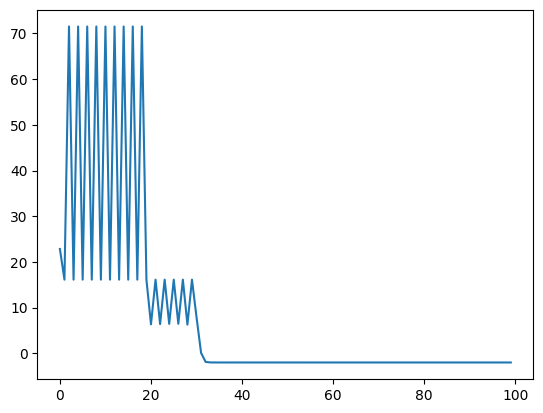

In [79]:
energies_np = [energy.detach().numpy().squeeze() for energy in energies]
plt.plot(energies_np)

In [30]:
max_steps = 1000
env = PushTEnv()
env.seed(10000)
obs, inf = env.reset()
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx=0
act = torch.randn((1, 2), device=device)
ebm = ebm.to(device)
ebm.eval()
with tqdm(total=max_steps, desc="Eval PushTStateEnv") as pbar:
    while not done:
        nobs = normalize_data(obs, stats=stats['obs'])
        nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)
        obs_cond = nobs.unsqueeze(0)
        act = langvin_sample(ebm, act, obs_cond, 1.0, 100, 0.5, 10)
        nact = act.detach().to('cpu').numpy()
        nact = nact[0]
        action = unnormalize_data(nact, stats=stats['action'])
        obs, reward, done, _, info = env.step(action)
        rewards.append(reward)
        imgs.append(env.render(mode='rgb_array'))
        step_idx += 1
        pbar.update(1)
        pbar.set_postfix(reward=reward)
        if step_idx>max_steps:
            done = True
        if done:
            break
print(obs)
print('Score:', max(rewards))
#from Ipython.display import Video
vwrite('vis.mp4', imgs)
#Video('vis.mp4', embed=True, width=256, height=256)

Eval PushTStateEnv:   0%|          | 0/1000 [00:00<?, ?it/s]

Eval PushTStateEnv: 1001it [01:32, 10.81it/s, reward=0]                          


[510.36964818  26.05042883 397.89067277 101.9998949    5.33543263]
Score: 0.0


In [39]:
nobs = normalize_data(obs, stats=stats['obs'])
nobs = torch.from_numpy(nobs)
obs_cond = nobs.unsqueeze(0)
plot_2d_ebm(-1, -1, 1, 1, ebm.cpu(), obs_cond, grid_size=200, alpha=None)

RuntimeError: mat1 and mat2 must have the same dtype